<a href="https://colab.research.google.com/github/ShahriarSAM/Grasp-Force-Estimation-of-Surgical-Robot-/blob/main/GraspForceEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


rawData = pd.read_csv('ThesisData.csv')
#rawData = rawData.loc[11622:293321, ['Grasp', 'AE1', 'AE2', 'loadcell']]
rawData = rawData.loc[8000:293321, ['Grasp', 'AE1', 'AE2', 'loadcell']]
rawData = rawData.to_numpy()
target = np.zeros(shape=(rawData.shape[0], 1))
for i in range(rawData.shape[0]):
  degree = (60/7.5)*(rawData[i, 0] - 4) + 63
  target[i] = (3*10**(-6))*(degree**2) + 0.0002*degree + 0.00004
rawData = np.append(rawData, target, axis=1)
print(rawData.shape)
#features = rawData[:, 0:3]
#target = rawData[:, 3]

scaler = MinMaxScaler()
#features = scaler.fit_transform(features)

rawData = scaler.fit_transform(rawData)

def build_timeseries(mat, y_col_index = 4):
    TIME_STEPS=30
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

def trim_dataset(mat, batch_size):
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

from tqdm import tqdm_notebook
BATCH_SIZE=32
x_t, y_t = build_timeseries(rawData, 4)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
#x_temp, y_temp = build_timeseries(x_test, 4)
X_train, X_test, y_train, y_test = train_test_split(x_t, y_t, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

(285322, 5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



length of time-series i/o (285292, 30, 5) (285292,)
(228224, 30, 5)
(228224,)


Epoch 1/30
5706/5706 [==============================] - 53s 6ms/step - loss: 0.0293 - val_loss: 0.0044
Epoch 2/30
5706/5706 [==============================] - 31s 5ms/step - loss: 0.0184 - val_loss: 0.0059
Epoch 3/30
5706/5706 [==============================] - 35s 6ms/step - loss: 0.0168 - val_loss: 0.0074
Epoch 4/30
5706/5706 [==============================] - 34s 6ms/step - loss: 0.0165 - val_loss: 0.0199
Epoch 5/30
5706/5706 [==============================] - 31s 5ms/step - loss: 0.0209 - val_loss: 0.0047
Epoch 6/30
5706/5706 [==============================] - 36s 6ms/step - loss: 0.0077 - val_loss: 0.0050
Epoch 7/30
5706/5706 [==============================] - 35s 6ms/step - loss: 0.0077 - val_loss: 0.0084
Epoch 8/30
5706/5706 [==============================] - 35s 6ms/step - loss: 0.0086 - val_loss: 0.0044
Epoch 9/30
5706/5706 [==============================] - 32s 6ms/step - loss: 0.0070 - val_loss: 0.0034
Epoch 10/30
5706/5706 [==============================] - 35s 6ms/step - l

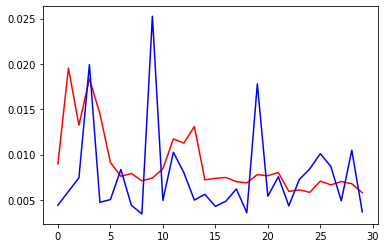

In [2]:
TIME_STEPS=30

model = Sequential()
model.add(SimpleRNN(20, input_shape=( 30, 5),
                    dropout=0.0, recurrent_dropout=0.2, stateful=False, kernel_initializer='random_uniform'))
#model.add(Dense(1024, activation='relu'))
#model.add(Dense(512, activation='relu'))
#model.add(Dense(256, activation = 'relu'))
#model.add(Dense(128, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(units = 1))

opt = Adam(learning_rate=0.1)
model.compile(optimizer = opt, loss = "mean_squared_error")
history = model.fit(X_train, y_train, epochs = 30, batch_size = 32,validation_split=0.2, shuffle='off')


plt.subplot()
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')


In [3]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
prediction = model.predict(X_test)
test_loss = model.evaluate(X_test, y_test)
mse = mean_squared_error(y_test, prediction)
r2 = r2_score(y_test, prediction)
print('Test - Loss for lstm :', test_loss)
print('Test - MSE for lstm :', mse)
print('Test - R2 Score for lstm :', r2)

1783/1783 [==============================] - 5s 2ms/step - loss: 0.0037
Test - Loss for lstm : 0.0036543949972838163
Test - MSE for lstm : 0.0036543944673966887
Test - R2 Score for lstm : 0.9807722868086158


(57056, 1)


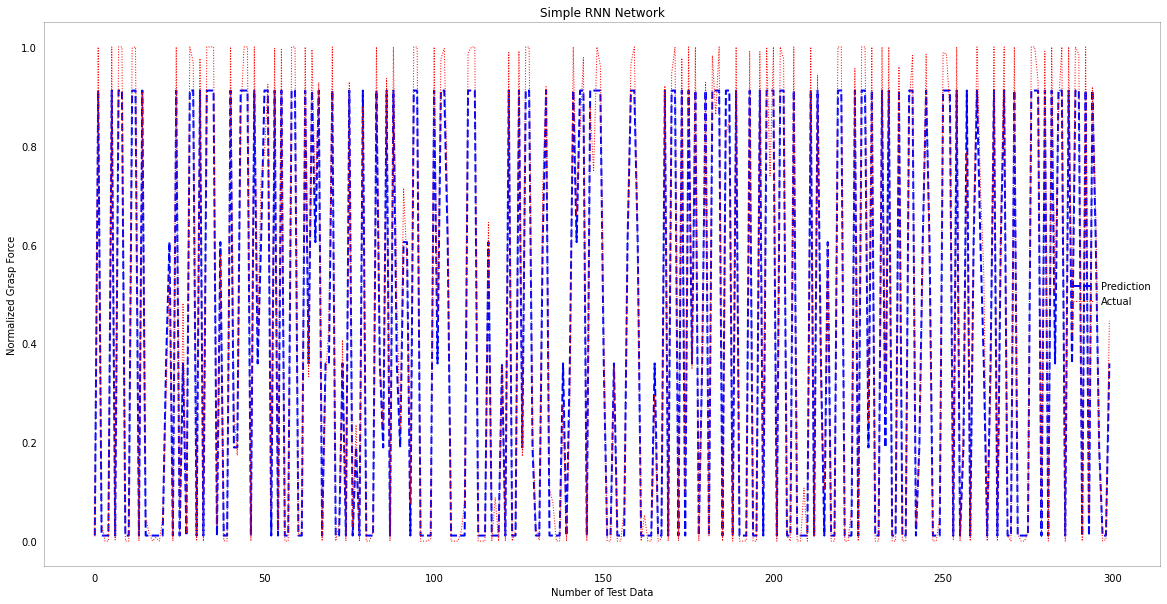

In [4]:

plt.figure(figsize = [20,10])
print(prediction.shape)
plt.plot(prediction[100:400], label='Prediction', linewidth=2, c='b', linestyle='--')
plt.plot(y_test[100:400], label='Actual', linewidth=1, c='r', linestyle=':')
plt.legend(frameon=False)
plt.xlabel('Number of Test Data')
plt.ylabel('Normalized Grasp Force')
plt.title("Simple RNN Network")
plt.tick_params(axis="both", which="both", bottom=False, top=False,    
                labelbottom=True, left=False, right=False, labelleft=True)   
plt.gca().spines["top"].set_alpha(.3)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.3)
plt.gca().spines["left"].set_alpha(.3)

In [5]:
model.save('SimpleRNNNetwork.h5')

In [6]:
from keras.models import load_model
model = load_model('SimpleRNNNetwork.h5')

In [7]:
rawData = pd.read_csv('ThesisData.csv')
rawData = rawData.loc[11622:293321, ['Grasp', 'AE1', 'AE2', 'loadcell']]
rawData = rawData.to_numpy()
target = np.zeros(shape=(rawData.shape[0], 1))
for i in range(rawData.shape[0]):
  degree = (60/7.5)*(rawData[i, 0] - 4) + 63
  target[i] = (3*10**(-6))*(degree**2) + 0.0002*degree + 0.00004
rawData = np.append(rawData, target, axis=1)
print(rawData.shape)
#features = rawData[:, 0:3]
#target = rawData[:, 3]

scaler = MinMaxScaler()
#features = scaler.fit_transform(features)

rawData = scaler.fit_transform(rawData)

def build_timeseries(mat, y_col_index = 4):
    TIME_STEPS=30
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

def trim_dataset(mat, batch_size):
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

from tqdm import tqdm_notebook
BATCH_SIZE=32
x_t, y_t = build_timeseries(rawData, 4)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
#x_temp, y_temp = build_timeseries(x_test, 4)
X_train, X_test, y_train, y_test = train_test_split(x_t, y_t, test_size=0.2, random_state=42, shuffle=False)

(281700, 5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



length of time-series i/o (281670, 30, 5) (281670,)


(56333, 1)


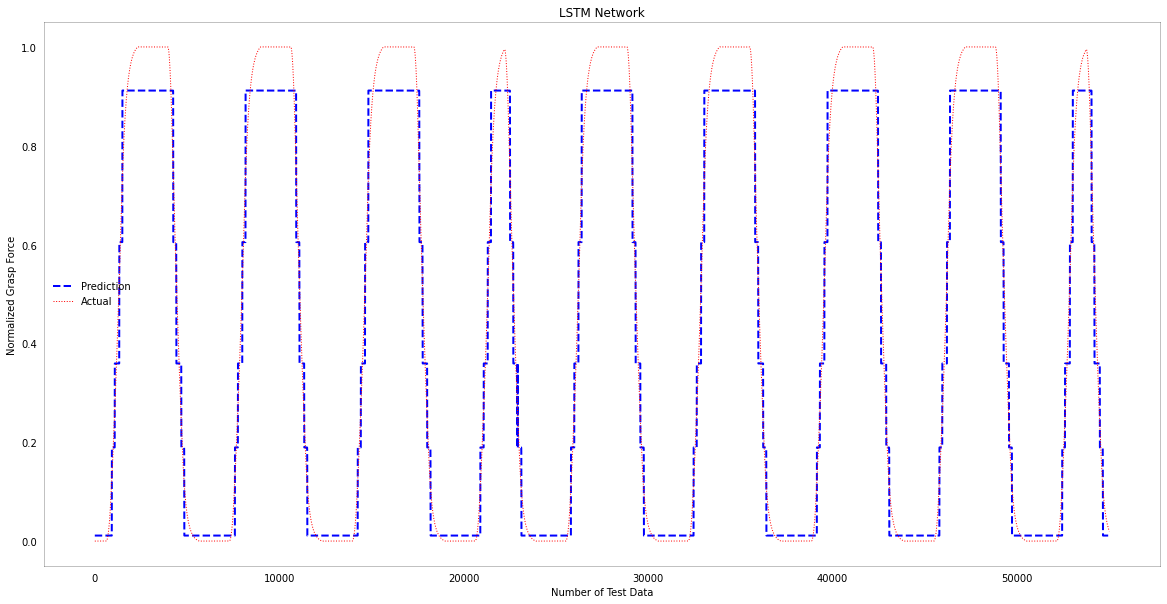

In [8]:
prediction = model.predict(X_test)
plt.figure(figsize = [20,10])
print(prediction.shape)
plt.plot(prediction[1000:56000], label='Prediction', linewidth=2, c='b', linestyle='--')
plt.plot(y_test[1000:56000], label='Actual', linewidth=1, c='r', linestyle=':')
plt.legend(frameon=False)
plt.xlabel('Number of Test Data')
plt.ylabel('Normalized Grasp Force')
plt.title("LSTM Network")
plt.tick_params(axis="both", which="both", bottom=False, top=False,    
                labelbottom=True, left=False, right=False, labelleft=True)   
plt.gca().spines["top"].set_alpha(.3)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.3)
plt.gca().spines["left"].set_alpha(.3)

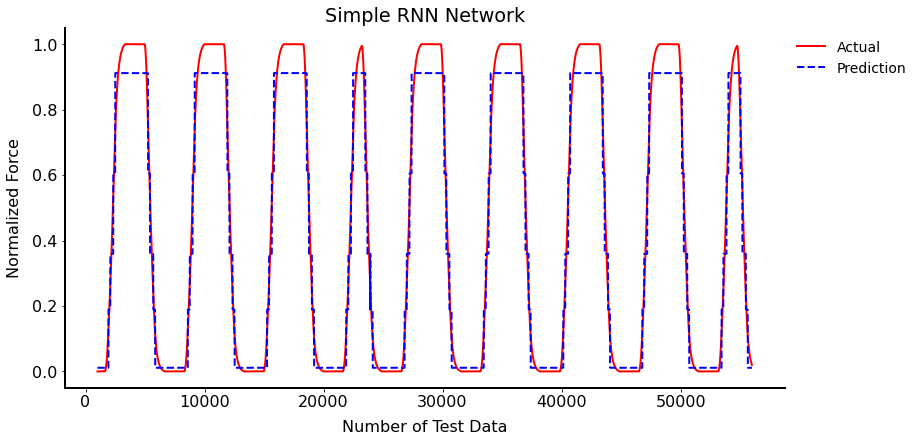

In [9]:
import matplotlib as mpl
from pylab import cm

#mpl.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2

colors = cm.get_cmap('rainbow', 2)

fig = plt.figure(figsize = [10,5])
ax = fig.add_axes([0, 0, 1, 1])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


ax.plot(np.linspace(1000, 56000, 55000), y_test[1000:56000], label='Actual', linewidth=2, c='r', linestyle='-')
ax.plot(np.linspace(1000, 56000, 55000), prediction[1000:56000], label='Prediction', linewidth=2, c='b', linestyle='--')

plt.legend(frameon=False)
ax.set_xlabel('Number of Test Data', labelpad=10)
ax.set_ylabel('Normalized Force', labelpad=10)
ax.set_title("Simple RNN Network")
#ax.set_title("Fully Connected Network")
#ax.set_title("Simple Recurrent Network")

ax.legend(bbox_to_anchor=(1, 1), loc=0, frameon=False, fontsize=14)

plt.savefig('SimpleRNNNetwork.png', dpi = 900, bbox_inches='tight')